# Generate Data

In [1]:
# Imports
from pathlib import Path
from tqdm import tqdm
from elements import elements
from mendeleev import element

from Code.cifSimulation import structureGenerator
from Code.h5Constructor import h5Constructor

import cProfile

## Cif generation

In [ ]:
# Path to dataset
datasetPath = './Dataset/CIFs/SimulatedTest2/'

# Initialize the CIF generator
generator = structureGenerator()

# Maximum number of atom species in generated structures
n_species = 2

# Choose required atoms to use
required_atoms = ['O']

# Choose optional atoms to use
metals = [atom.Symbol for atom in elements.Alkali_Metals] 
metals += [atom.Symbol for atom in elements.Alkaline_Earth_Metals] 
metals += [atom.Symbol for atom in elements.Transition_Metals] 
metals += [atom.Symbol for atom in elements.Metalloids] 
metals += [atom.Symbol for atom in elements.Others]

optional_atoms = []
for metal in metals:
    try:
        elm_data = element(metal)
        if elm_data.metallic_radius or elm_data.atomic_radius:
            optional_atoms.append(metal)
        else:
            print(f'Removed {metal} from dataset as no table values were available.')
    except:
        print(f'Removed {metal} from dataset as no table values were available.')
optional_atoms = ['Zn', 'Nb']

# Simulate mono-metal oxides
generator.create_cif_dataset(
    n_species=n_species,
    required_atoms=required_atoms,
    optional_atoms=optional_atoms,
    from_table_values=False,
    save_folder=datasetPath,
)

## Query COD

In [ ]:
from pathlib import Path
import requests
import zipfile
import io
from multiprocessing import Pool, cpu_count
from itertools import islice, repeat
from tqdm.auto import tqdm
import argparse
from elements import elements
from mendeleev import element
import pandas as pd

In [ ]:
metals = [atom.Symbol for atom in elements.Alkali_Metals] 
metals += [atom.Symbol for atom in elements.Alkaline_Earth_Metals] 
metals += [atom.Symbol for atom in elements.Transition_Metals] 
metals += [atom.Symbol for atom in elements.Metalloids] 
metals += [atom.Symbol for atom in elements.Others] # Post-transition metals
metals += ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb',
           'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu'] # Lanthanides

# Remove elements that does not have a well defined radius or are rare in nanoparticles
unwanted_elements = ['Fr', 'Po', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Uub', 'Uun', 'Uuu']
for elm in unwanted_elements:
    metals.remove(elm)
    
print(len(metals))

In [ ]:
non_metals = [atom.Symbol for atom in elements.Non_Metals]
non_metals += [atom.Symbol for atom in elements.Halogens]
non_metals.remove('At')

print(len(non_metals))

In [ ]:
# Find all possible two element combinations of metals and non-metals
combinations = []
for metal in metals:
    for non_metal in non_metals:
        combinations.append(([metal, non_metal], []))

for metal in metals:
    combinations.append(([metal], non_metals))

print(len(combinations))

In [ ]:
def queryCOD_new(input_tuple):
    (included_atoms, excluded_atoms), max_volume = input_tuple

    id_url = 'https://www.crystallography.net/cod/result?format=lst'
    if included_atoms:
        for i, included_atom in enumerate(included_atoms):
            id_url += f'&el{i+1}={included_atom}'
    if excluded_atoms:
        for i, excluded_atom in enumerate(excluded_atoms):
            id_url += f'&nel{i+1}={excluded_atom}'
    if max_volume:
        id_url += f'&vmax={max_volume}'
    
    id_response = requests.get(id_url)

    return id_response.text.split('\n')

In [ ]:
inputs = zip(combinations, repeat(1000))
id_list = []
with Pool(processes=cpu_count()-1) as pool:
    with tqdm(total=len(combinations), desc='Querying COD') as pbar:
        for returned_ids in pool.imap_unordered(queryCOD_new, inputs, chunksize=1):
            id_list.extend(returned_ids)
            pbar.update()

In [ ]:
df_ids = pd.DataFrame(id_list)
print(len(df_ids))
df_ids = df_ids.drop_duplicates()
print(len(df_ids))
df_ids.to_csv('./test_cif_IDs.csv', index=False, header=False)

In [ ]:
from Code.cifCleaning import cif_cleaning_pipeline
from Code.databaseQuery import queryCOD

# Path to dataset
cif_folder = './Dataset/CIFs/COD_subset/'

# Path to CIF ID list
id_list_path = './COD_subset_IDs.csv'

queryCOD(cif_folder, id_file=id_list_path)

In [ ]:
df_cifs = cif_cleaning_pipeline(cif_folder, chunksize=100)

In [ ]:
df_cifs.head()

In [ ]:
df_cifs[(df_cifs['Element0'] == 6) & (df_cifs['Element1'] == 8) & (df_cifs['Element2'].isna())]

In [ ]:
from ase.io import read
cif = read(df_cifs['filepath'].iloc[19477], format='cif')

In [ ]:
cif.symbols

In [ ]:
metals

In [ ]:
metal_numbers = [element(metal).atomic_number for metal in metals]
metal_numbers

In [ ]:
# df_cifs.columns.difference(['filepath', 'Spacegroup'])
contains_metals = df_cifs.apply(lambda row: any(atom in metal_numbers for atom in row[2:].values), axis=1)

In [ ]:
sum(~contains_metals)

In [ ]:
df_cifs[~contains_metals]

In [ ]:
# Cout nan values
df_cifs[df_cifs['Element1'].isna()].sort_values(by='filepath')

In [ ]:
from ase.io import read
from tqdm.auto import trange
metal_cifs = df_cifs[df_cifs['Element1'].isna()].sort_values(by='filepath')


In [ ]:
unit_cell = read(metal_cifs['filepath'].iloc[7].replace('_cleaned', ''))
print(unit_cell.get_chemical_formula())
print(unit_cell.get_chemical_symbols())
print(unit_cell.cell.cellpar())


In [ ]:
df_cifs.columns

In [ ]:
columns = ['Spacegroup', 'Element0', 'Element1', 'Element2',
       'Element3', 'Element4', 'Element5', 'Element6', 'Element7', 'Element8',
       'Element9', 'Element10']
for i in trange(len(df_cifs)):
    specific_row = df_cifs.iloc[i]

    duplicate_cifs = df_cifs[(df_cifs[columns] == specific_row[columns]).all(axis=1)]
    if len(duplicate_cifs) > 0:
        print(specific_row)
        print(duplicate_cifs.head())
        break



## .h5 generation

In [2]:
gc = h5Constructor(cif_dir='./Dataset/CIFs/SimulatedTest/', save_dir='./Dataset/h5/SimulatedTest2/')
# cProfile.run('gc.gen_h5s(parallelize=False, device="cuda")', sort='tottime')
gc.gen_h5s(parallelize=False, device='cuda', np_radii=[5, 10, 15, 20, 25])

Rutile_MoO2
NaCl_MoO
AntiFluorite_Co2O
Wurtzite_IrO
AntiFluorite_Pt2O
Wurtzite_CoO
ReO3_IrO3
Wurtzite_MoO
Spinel_FeFe2O4
CdI2_FeO2
AntiFluorite_Mo2O
Rutile_IrO2
Rutile_PtO2
ReO3_PtO3
AntiFluorite_Fe2O
NaCl_PtO
CdI2_CoO2
Wurtzite_PtO
NaCl_FeO
NaCl_IrO
Wurtzite_FeO
CdI2_MoO2
Fluorite_FeO2
Spinel_PtPt2O4
Spinel_MoMo2O4
Fluorite_CoO2
Fluorite_PtO2
Rutile_FeO2
CdI2_PtO2
ReO3_CoO3
Fluorite_MoO2
ReO3_MoO3
Spinel_IrIr2O4
AntiFluorite_Ir2O
ReO3_FeO3
Rutile_CoO2
NaCl_CoO
Spinel_CoCo2O4
Fluorite_IrO2
CdI2_IrO2


## Create unit cell graph

In [2]:
#%% Imports
import os, sys, math, torch
from mendeleev import element
from mendeleev.fetch import fetch_table
import numpy as np
from tqdm.auto import tqdm
import h5py
from itertools import repeat
from multiprocessing import Pool, cpu_count
from pathlib import Path
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from networkx.algorithms.components import is_connected
from ase.io import read
from ase.build import make_supercell
from ase.spacegroup import get_spacegroup
from ase.visualize import view
# from Code.simScatteringPatterns import simPDFs, cif_to_NP_GPU
from debyecalculator import DebyeCalculator
from elements import elements
from mendeleev import element
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.core.structure import Structure
from pymatgen.analysis.local_env import CrystalNN, MinimumDistanceNN
from pymatgen.io.ase import AseAtomsAdaptor
from timeit import default_timer as timer

In [3]:
# Path to cif file
# cif = './Dataset/CIFs/COD_subset_cleaned/1000023.cif'
#cif = './Dataset/CIFs/COD_subset_cleaned/1008022.cif'
cif = './Dataset/CIFs/COD_subset_cleaned/5910132.cif'

# Load cif
unit_cell = read(cif)

# Find spacegroup
spacegroup = get_spacegroup(unit_cell)

/home/ufj/anaconda3/envs/dataset_env/lib/python3.10/site-packages/ase/io/cif.py:401: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(88, setting=1). This may result in wrong setting!
  warnings.warn(
/home/ufj/anaconda3/envs/dataset_env/lib/python3.10/site-packages/ase/spacegroup/spacegroup.py:433: UserWarning: scaled_positions 0 and 2 are equivalent
  warnings.warn('scaled_positions %d and %d '
/home/ufj/anaconda3/envs/dataset_env/lib/python3.10/site-packages/ase/spacegroup/spacegroup.py:433: UserWarning: scaled_positions 1 and 3 are equivalent
  warnings.warn('scaled_positions %d and %d '
/home/ufj/anaconda3/envs/dataset_env/lib/python3.10/site-packages/ase/spacegroup/spacegroup.py:433: UserWarning: scaled_positions 1 and 5 are equivalent
  warnings.warn('scaled_positions %d and %d '
/home/ufj/anaconda3/envs/dataset_env/lib/python3.10/site-packages/ase/spacegroup/spacegroup.py:433: UserWarning: scaled_positions 4 and 6 are equivalent
  warnings.

In [4]:
unit_cell.get_all_distances(mic=True)

array([[0.        , 3.70130214, 3.70130214, ..., 5.74189944, 1.17578831,
        4.28343538],
       [3.70130214, 0.        , 6.85058574, ..., 2.72219005, 4.28343538,
        5.74189944],
       [3.70130214, 6.85058574, 0.        , ..., 4.28343538, 2.72219005,
        1.17578831],
       ...,
       [5.74189944, 2.72219005, 4.28343538, ..., 0.        , 6.3706946 ,
        3.24457236],
       [1.17578831, 4.28343538, 2.72219005, ..., 6.3706946 , 0.        ,
        3.24457236],
       [4.28343538, 5.74189944, 1.17578831, ..., 3.24457236, 3.24457236,
        0.        ]])

In [ ]:
unit_cell.get_chemical_symbols()

In [ ]:
unit_cell.get_scaled_positions()

In [ ]:
# view(unit_cell, viewer='ngl')

In [ ]:
node_feature_table = fetch_table('elements')[['atomic_number', 'atomic_radius', 'atomic_weight', 'electron_affinity']]
node_feature_table['electron_affinity'].fillna(0.0, inplace=True)

# Metals of interest
metals = [atom.Symbol for atom in elements.Alkali_Metals] 
metals += [atom.Symbol for atom in elements.Alkaline_Earth_Metals] 
metals += [atom.Symbol for atom in elements.Transition_Metals] 
metals += [atom.Symbol for atom in elements.Metalloids] 
metals += [atom.Symbol for atom in elements.Others] # Post-transition metals
metals += ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb',
        'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu'] # Lanthanides

# Remove elements that does not have a well defined radius or are rare in nanoparticles
unwanted_elements = ['Fr', 'Po', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Uub', 'Uun', 'Uuu']
for elm in unwanted_elements:
    metals.remove(elm)
    
# Convert to atomic numbers
metals = [element(metal).atomic_number for metal in metals]

In [ ]:
import plotly.graph_objects as go

def plot_atoms_and_bonds(node_pos_real, node_features, direction, edge_features):
    
    jmol_colors = [
        "#FFFFFF", "#8F8F8F", "#D9FFFF", "#CC80FF", "#C2FF00", "#FFB5B5", "#909090", "#3050F8", "#FF0D0D", "#90E050",
        "#B3E3F5", "#AB5CF2", "#8AFF00", "#BFA6A6", "#F0C8A0", "#FF8000", "#FFFF30", "#1FF01F", "#80D1E3", "#8F40D4",
        "#3DFF00", "#E6E6E6", "#BFC2C7", "#A6A6AB", "#8A99C7", "#9C7AC7", "#E06633", "#F090A0", "#50D050", "#C88033",
        "#7D80B0", "#C28F8F", "#668F8F", "#BD80E3", "#FFA100", "#A62929", "#5CB8D1", "#702EB0", "#00FF00", "#94FFFF",
        "#94E0E0", "#73C2C9", "#54B5B5", "#3B9E9E", "#248F8F", "#0A7D8C", "#006985", "#C0C0C0", "#FFD98F", "#A67573",
        "#668080", "#9E63B5", "#D47A00", "#940094", "#429EB0", "#57178F", "#00C900", "#70D4FF", "#FFFFC7", "#D9FFC7",
        "#C7FFC7", "#A3FFC7", "#8FFFC7", "#61FFC7", "#45FFC7", "#30FFC7", "#1FFFC7", "#00FF9C", "#00E675", "#00D452",
        "#00BF38", "#00AB24", "#4DC2FF", "#4DA6FF", "#2194D6", "#267DAB", "#266696", "#175487", "#D0D0E0", "#FFD123",
        "#B8B8D0", "#A6544D", "#575961", "#9E4FB5", "#AB5C00", "#754F45", "#428296", "#420066", "#007D00", "#70ABFA",
        "#00BAFF", "#00A1FF", "#008FFF", "#0080FF", "#006BFF", "#545CF2", "#785CE3", "#8A4FE3", "#A136D4", "#B31FD4",
        "#B31FBA", "#B30DA6", "#BD0D87", "#C70066", "#CC0059", "#D1004F", "#D90045", "#E00038", "#E6002E", "#EB0026",
        "#EB0026", "#F1001E"
    ]
    
    # Create a figure
    fig = go.Figure()
    
    # Add atoms to the figure
    for i in range(len(node_pos_real)):
        atom = node_pos_real[i]
        fig.add_trace(go.Scatter3d(
            x=[atom[0]],
            y=[atom[1]],
            z=[atom[2]],
            mode='markers',
            marker=dict(
                size=5,
                color=jmol_colors[int(node_features[i][0])],
            ),
            name=f'Atom {i+1}\n({node_features[i][0]})'
        ))

    # Add bonds to the figure
    for i in range(len(direction[0])):
        atom1 = node_pos_real[direction[0][i]]
        atom2 = node_pos_real[direction[1][i]]
        fig.add_trace(go.Scatter3d(
            x=[atom1[0], atom2[0]],
            y=[atom1[1], atom2[1]],
            z=[atom1[2], atom2[2]],
            mode='lines',
            line=dict(
                color='black',
                width=2
            ),
            name=f'Bond {i+1}\n({edge_features[i]:.2f})'
        ))

    # Set layout
    fig.update_layout(
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z')
        ),
        title='Atom Positions and Bonds',
        showlegend=True
    )

    # Show the figure
    fig.show()

In [ ]:
start = timer()
# Get distances with MIC (NOTE I don't think this makes a difference as long as pbc=True in the unit cell)
unit_cell_dist = unit_cell.get_all_distances(mic=True)
unit_cell_atoms = unit_cell.get_atomic_numbers().reshape(-1, 1)

# Make supercell to get Lattice constant
supercell = make_supercell(unit_cell, np.diag([2,2,2]))
# supercell = unit_cell
metal_distances = supercell[supercell.get_atomic_numbers() != 8].get_all_distances()
lc = np.amin(metal_distances[metal_distances > 0.])

# Create edges and node features
lc_mask = (unit_cell_dist > 0) & (unit_cell_dist < lc)
oxy_mask = np.outer(unit_cell_atoms == 8, unit_cell_atoms == 8)
metal_mask = np.outer(unit_cell_atoms != 8, unit_cell_atoms !=8)
direction = np.argwhere(lc_mask & ~oxy_mask & ~metal_mask).T

edge_features = unit_cell_dist[direction[0], direction[1]]
node_features = np.array([
    node_feature_table.loc[atom[0]-1].values
    for atom in unit_cell_atoms
    ], dtype='float')
node_pos_real = unit_cell.get_positions()
node_pos_relative = unit_cell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2e} s')
print(f'Number of edges: {len(direction[0])}')
# plot_atoms_and_bonds(node_pos_real, node_features, direction, edge_features)

In [ ]:
start = timer()
# Get distances with MIC (NOTE I don't think this makes a difference as long as pbc=True in the unit cell)
unit_cell_dist = unit_cell.get_all_distances(mic=True)
unit_cell_atoms = unit_cell.get_atomic_numbers().reshape(-1, 1)

# metal_filter = np.isin(unit_cell_atoms, metals)

# Find node features
node_features = np.array([
    node_feature_table.loc[atom[0]-1].values
    for atom in unit_cell_atoms
    ], dtype='float')

# Create mask of threshold for bonds
bond_threshold = np.zeros_like(unit_cell_dist)
for i, r1 in enumerate(node_features[:,1]):
    bond_threshold[i,:] = (r1 + node_features[:,1]) / 100 * 1.25
np.fill_diagonal(bond_threshold, 0.)

# Find edges
direction = np.argwhere(unit_cell_dist < bond_threshold).T

edge_features = unit_cell_dist[direction[0], direction[1]]

node_pos_real = unit_cell.get_positions()
node_pos_relative = unit_cell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2e} s')
print(f'Number of edges: {len(direction[0])}')
# plot_atoms_and_bonds(node_pos_real, node_features, direction, edge_features)

In [ ]:
unit_cell_atoms.T

In [ ]:
direction

In [ ]:
node_pos_relative

In [ ]:
start = timer()
# Get distances with MIC (NOTE I don't think this makes a difference as long as pbc=True in the unit cell)
unit_cell_dist = unit_cell.get_all_distances(mic=True)
unit_cell_atoms = unit_cell.get_atomic_numbers().reshape(-1, 1)

# Create edges and node features
struc = AseAtomsAdaptor.get_structure(unit_cell)
crystal_nn = CrystalNN()
strucGraph = StructureGraph.with_local_env_strategy(struc, crystal_nn)
direction = np.array(strucGraph.graph.edges)[:,:2].T

edge_features = unit_cell_dist[direction[0], direction[1]]
node_features = np.array([
    node_feature_table.loc[atom[0]-1].values
    for atom in unit_cell_atoms
    ], dtype='float')
node_pos_real = unit_cell.get_positions()
node_pos_relative = unit_cell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2e} s')
print(f'Number of edges: {len(direction[0])}')
# plot_atoms_and_bonds(node_pos_real, node_features, direction, edge_features)

In [ ]:
start = timer()
# Get distances with MIC (NOTE I don't think this makes a difference as long as pbc=True in the unit cell)
unit_cell_dist = unit_cell.get_all_distances(mic=True)
unit_cell_atoms = unit_cell.get_atomic_numbers().reshape(-1, 1)

# Create edges and node features
struc = AseAtomsAdaptor.get_structure(unit_cell)
crystal_nn = CrystalNN(distance_cutoffs=None, x_diff_weight=0.0, porous_adjustment=False)
strucGraph = StructureGraph.with_local_env_strategy(struc, crystal_nn)
direction = np.array(strucGraph.graph.edges)[:,:2].T

edge_features = unit_cell_dist[direction[0], direction[1]]
node_features = np.array([
    node_feature_table.loc[atom[0]].values
    for atom in unit_cell_atoms
    ], dtype='float')
node_pos_real = unit_cell.get_positions()
node_pos_relative = unit_cell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2e} s')
print(f'Number of edges: {len(direction[0])}')
# plot_atoms_and_bonds(node_pos_real, node_features, direction)

In [ ]:
start = timer()
# Get distances with MIC (NOTE I don't think this makes a difference as long as pbc=True in the unit cell)
unit_cell_dist = unit_cell.get_all_distances(mic=True)
unit_cell_atoms = unit_cell.get_atomic_numbers().reshape(-1, 1)

# Create edges and node features
struc = AseAtomsAdaptor.get_structure(unit_cell)
minimum_nn = MinimumDistanceNN()
strucGraph = StructureGraph.with_local_env_strategy(struc, minimum_nn)
direction = np.array(strucGraph.graph.edges)[:,:2].T

edge_features = unit_cell_dist[direction[0], direction[1]]
node_features = np.array([
    node_feature_table.loc[atom[0]-1].values
    for atom in unit_cell_atoms
    ], dtype='float')
node_pos_real = unit_cell.get_positions()
node_pos_relative = unit_cell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2e} s')
print(f'Number of edges: {len(direction[0])}')
# plot_atoms_and_bonds(node_pos_real, node_features, direction, edge_features)

## Create supercell graph

In [ ]:
r_max = 10 # Maximum radius of the particle
cell_dims = unit_cell.cell.cellpar()[:3] # Get the cell dimensions
padding = 2 # Symmetric padding to ensure the particle does not exceed the supercell boundary
supercell_matrix = np.diag((np.ceil(r_max / cell_dims)) * 2 + padding)
supercell = make_supercell(prim=unit_cell, P=supercell_matrix)
# supercell = make_supercell(unit_cell, np.diag([2,2,2]))
# supercell.center(about=0)
supercell.get_positions().max(axis=0)

In [ ]:
cell_dims

In [ ]:
unit_cell.get_positions().max(axis=0)

In [ ]:
view(supercell, viewer='ngl')

In [ ]:
from pymatgen.analysis.local_env import CrystalNN, MinimumDistanceNN, IsayevNN, JmolNN, MinimumOKeeffeNN, MinimumVIRENN, OpenBabelNN, VoronoiNN

In [ ]:
# Setup of structure and local neighborhood strategies
struc = AseAtomsAdaptor.get_structure(supercell)
crystal_nn = CrystalNN()
minDist_nn = MinimumDistanceNN()
isayev_nn = IsayevNN()
jmol_nn = JmolNN()
keeffe_nn = MinimumOKeeffeNN()
viree_nn = MinimumVIRENN()
voronoi_nn = VoronoiNN()

In [ ]:
# CrystalNN
start_crystalNN = timer()
# Find edges
strucGraph = StructureGraph.with_local_env_strategy(struc, crystal_nn)
stop_crystalNN = timer()
# Save number of edges
nEdges_crystalNN = np.array(strucGraph.graph.edges)[:,:2].T.shape[1]


In [ ]:
# MinimumDistanceNN
start_minDistNN = timer()
# Find edges
strucGraph = StructureGraph.with_local_env_strategy(struc, minDist_nn)
stop_minDistNN = timer()
# Save number of edges
nEdges_minDistNN = np.array(strucGraph.graph.edges)[:,:2].T.shape[1]



In [ ]:
# IsayevNN
start_isayevNN = timer()
# Find edges
strucGraph = StructureGraph.with_local_env_strategy(struc, isayev_nn)
stop_isayevNN = timer()
# Save number of edges
nEdges_isayevNN = np.array(strucGraph.graph.edges)[:,:2].T.shape[1]



In [ ]:
# JmolNN
start_jmolNN = timer()
# Find edges
strucGraph = StructureGraph.with_local_env_strategy(struc, jmol_nn)
stop_jmolNN = timer()
# Save number of edges
nEdges_jmolNN = np.array(strucGraph.graph.edges)[:,:2].T.shape[1]



In [ ]:
# MinimumOKeeffeNN
start_okeeffeNN = timer()
# Find edges
strucGraph = StructureGraph.with_local_env_strategy(struc, keeffe_nn)
stop_okeeffeNN = timer()
# Save number of edges
nEdges_okeeffeNN = np.array(strucGraph.graph.edges)[:,:2].T.shape[1]



In [ ]:
# MinimumVIRENN
start_vireeNN = timer()
# Find edges
strucGraph = StructureGraph.with_local_env_strategy(struc, viree_nn)
stop_vireeNN = timer()
# Save number of edges
nEdges_vireeNN = np.array(strucGraph.graph.edges)[:,:2].T.shape[1]



In [ ]:
# VoronoiNN
start_voronoiNN = timer()
# Find edges
strucGraph = StructureGraph.with_local_env_strategy(struc, voronoi_nn)
stop_voronoiNN = timer()
# Save number of edges
nEdges_voronoiNN = np.array(strucGraph.graph.edges)[:,:2].T.shape[1]



In [ ]:
print('Timing results:')
print('_________________________________________________________')
print('Method | Time (s) | Number of edges')
print('_________________________________________________________')
print(f'CrystalNN | {stop_crystalNN-start_crystalNN:.2e} | {nEdges_crystalNN}')
print(f'MinimumDistanceNN | {stop_minDistNN-start_minDistNN:.2e} | {nEdges_minDistNN}')
# print(f'IsayevNN | {stop_isayevNN-start_isayevNN:.2e} | {nEdges_isayevNN}')
print(f'JmolNN | {stop_jmolNN-start_jmolNN:.2e} | {nEdges_jmolNN}')
print(f'MinimumOKeeffeNN | {stop_okeeffeNN-start_okeeffeNN:.2e} | {nEdges_okeeffeNN}')
# print(f'MinimumVIRENN | {stop_vireeNN-start_vireeNN:.2e} | {nEdges_vireeNN}')
# print(f'VoronoiNN | {stop_voronoiNN-start_voronoiNN:.2e} | {nEdges_voronoiNN}')
print('_________________________________________________________')

In [ ]:
start = timer()
supercell_dist = supercell.get_all_distances(mic=False)
supercell_atoms = supercell.get_atomic_numbers().reshape(-1, 1)

# Create edges and node features
struc = AseAtomsAdaptor.get_structure(supercell)
crystal_nn = CrystalNN()
strucGraph = StructureGraph.with_local_env_strategy(struc, crystal_nn)
direction = np.array(strucGraph.graph.edges)[:,:2].T

edge_features = supercell_dist[direction[0], direction[1]]
node_features = np.array([
    node_feature_table.loc[atom[0]].values
    for atom in supercell_atoms
    ], dtype='float')
node_pos_real = supercell.get_positions()
node_pos_relative = supercell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2f} s')
print(f'Number of edges: {len(direction[0])}')
#plot_atoms_and_bonds(node_pos_real, node_features, direction)

In [ ]:
start = timer()
# Get distances with MIC (NOTE I don't think this makes a difference as long as pbc=True in the unit cell)
supercell_dist = supercell.get_all_distances(mic=False)
supercell_atoms = supercell.get_atomic_numbers().reshape(-1, 1)

# metal_filter = np.isin(unit_cell_atoms, metals)

# Find node features
node_features = np.array([
    node_feature_table.loc[atom[0]-1].values
    for atom in supercell_atoms
    ], dtype='float')

# Create mask of threshold for bonds
bond_threshold = np.zeros_like(supercell_dist)
for i, r1 in enumerate(node_features[:,1]):
    bond_threshold[i,:] = (r1 + node_features[:,1]) / 100 * 1.25
np.fill_diagonal(bond_threshold, 0.)

# Find edges
direction = np.argwhere(supercell_dist < bond_threshold).T

# Handle case with no edges
if len(direction[0]) == 0:
    min_dist = np.amin(supercell_dist[supercell_dist > 0])
    direction = np.argwhere(supercell_dist < min_dist * 1.1).T
    
edge_features = supercell_dist[direction[0], direction[1]]

node_pos_real = supercell.get_positions()
node_pos_relative = supercell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2e} s')
print(f'Number of edges: {len(direction[0])}')
#plot_atoms_and_bonds(node_pos_real, node_features, direction, edge_features)

In [ ]:
len(direction[0])

In [ ]:
start = timer()
supercell_dist = supercell.get_all_distances(mic=False)
supercell_atoms = supercell.get_atomic_numbers().reshape(-1, 1)

# Create edges and node features
struc = AseAtomsAdaptor.get_structure(supercell)
crystal_nn = CrystalNN(distance_cutoffs=None, x_diff_weight=0.0, porous_adjustment=False)
strucGraph = StructureGraph.with_local_env_strategy(struc, crystal_nn)
direction = np.array(strucGraph.graph.edges)[:,:2].T

edge_features = supercell_dist[direction[0], direction[1]]
node_features = np.array([
    node_feature_table.loc[atom[0]].values
    for atom in supercell_atoms
    ], dtype='float')
node_pos_real = supercell.get_positions()
node_pos_relative = supercell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2f} s')
print(f'Number of edges: {len(direction[0])}')
#plot_atoms_and_bonds(node_pos_real, node_features, direction)

In [ ]:
start = timer()
supercell_dist = supercell.get_all_distances(mic=False)
supercell_atoms = supercell.get_atomic_numbers().reshape(-1, 1)

# Create edges and node features
struc = AseAtomsAdaptor.get_structure(supercell)
minDist_nn = MinimumDistanceNN()
strucGraph = StructureGraph.with_local_env_strategy(struc, minDist_nn)
direction = np.array(strucGraph.graph.edges)[:,:2].T

edge_features = supercell_dist[direction[0], direction[1]]
node_features = np.array([
    node_feature_table.loc[atom[0]].values
    for atom in supercell_atoms
    ], dtype='float')
node_pos_real = supercell.get_positions()
node_pos_relative = supercell.get_scaled_positions()

stop = timer()
print(f'Time to create graph: {stop-start:.2f} s')
print(f'Number of edges: {len(direction[0])}')
#plot_atoms_and_bonds(node_pos_real, node_features, direction)


## Misc

In [ ]:
from mendeleev import element
from mendeleev.fetch import fetch_table

In [ ]:
node_feature_table = fetch_table('elements')[['atomic_number', 'atomic_radius', 'atomic_weight', 'electron_affinity']]

In [ ]:
node_feature_table.describe()

In [ ]:
node_feature_table['electron_affinity'].fillna(0.0, inplace=True)

In [ ]:
node_feature_table['atomic_radius']

In [ ]:
node_feature_table.describe()

In [ ]:
import numpy as np

# Define the element symbol
element_symbol = 'O'

# Get the row corresponding to the element symbol
element_row = node_feature_table[node_feature_table['symbol'] == element_symbol]

# Extract the required features as a numpy array
element_features = element_row[['atomic_number', 'atomic_radius', 'atomic_weight', 'electron_affinity']].to_numpy()


In [ ]:
element_features.flatten()

# Load and inspect data

In [1]:
from Code.datasetClass import InOrgMatDatasets
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from mendeleev import element
from tqdm.auto import tqdm
warnings.simplefilter(action='ignore') # , category=FutureWarning

# dataset = InOrgMatDatasets('COD_subset_v4', root='./Dataset/')

In [8]:
dataset1 = InOrgMatDatasets('COD_subset_v4', root='./Dataset/')
# dataset1.create_data_split()
# dataset1.create_data_split(split_strategy='stratified', stratify_on='Crystal system (Number)')
dataset1.create_data_split(split_strategy='stratified', stratify_on='Crystal system (Number)', n_samples_per_class='even')

dataset2 = InOrgMatDatasets('Simulated_rmax60_v4', root='./Dataset/')
# dataset2.create_data_split()
# dataset2.create_data_split(split_strategy='stratified', stratify_on='Crystal system (Number)')
dataset2.create_data_split(split_strategy='stratified', stratify_on='Crystal system (Number)', n_samples_per_class='even')

In [ ]:
# import subprocess
# from pathlib import Path

# # Define the command line commands
# paths = ['./' + str(config_file) for config_file in Path('./benchmark_configs/').glob('*.yaml')]

# commands = [f'python benchmarking.py --config={path}' for path in paths]

# # Run the commands
# for command in commands:
#     subprocess.run(command, shell=True)


In [13]:
dataset1.load_data_split(split_strategy='stratified', stratify_on='Crystal system (Number)', n_samples_per_class='even')
dataset2.load_data_split(split_strategy='stratified', stratify_on='Crystal system (Number)', n_samples_per_class='even')

In [50]:
# idx = 1
# print(dataset.len())
# print(dataset.get(idx).y['atomic_species'])
# print(dataset.get(idx))

In [51]:
# print(dataset.len(split='train'), dataset.len(split='validation'), dataset.len(split='test'))
# dataset.get(1, split='test')

## Create .xyz file

In [52]:
# # Loop over all indices in the dataset
# for idx in tqdm(range(dataset.len())):
#     # Get the sample at an index
#     # idx = 9
#     sample = dataset.get(idx)

#     # Extract the absolute coordinates and atomic numbers
#     coords = sample.pos_abs.numpy()
#     atomic_numbers = sample.x[:,0].numpy().astype(int)
#     n_atoms = sample.y['n_atoms']

#     # Write the .xyz file
#     with open(f'./Dataset/xyz/SimulatedTest2/{idx}.xyz', 'w') as f:
#         f.write(f'{n_atoms}\n')
#         f.write('\n')
#         for i in range(n_atoms):
#             f.write(f'{element(int(atomic_numbers[i])).symbol} {coords[i,0]} {coords[i,1]} {coords[i,2]}\n')


## Plotting and statistics

In [53]:
# plt.figure(figsize=(10, 6))
# plt.plot(*dataset.get(540, split='train').y['xPDF'])
# plt.ylabel('Intensity (a.u.)')
# plt.xlabel('r ($\AA$)')
# plt.show()

In [14]:
stats1 = dataset1.get_statistics(return_dataframe=True)
stats1.describe()

,idx,# of nodes,# of edges,# of elements,Space group (Number),Crystal system (Number),NP size (Å)
count,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000
mean,51357.335798,1740.171765,11923.577479,3.089076,82.486723,2.511597,33.446225
std,30359.813162,1929.350743,15434.453692,0.852899,78.068950,1.844433,14.857823
min,14.000000,4.000000,7.000000,1.000000,1.000000,0.000000,3.381753
25%,24647.000000,226.000000,972.000000,3.000000,14.000000,1.000000,22.654082
50%,51069.000000,1078.000000,5580.000000,3.000000,62.000000,2.000000,34.229324
75%,77349.500000,2782.000000,17558.000000,4.000000,140.000000,3.000000,45.457628
max,104325.000000,10803.000000,113364.000000,6.000000,229.000000,6.000000,59.347755


In [15]:
print(dataset1.len(split='train'))
print(dataset1.len(split='validation'))
print(dataset1.len(split='test'))

2381
297
297


In [16]:
stats2 = dataset2.get_statistics(return_dataframe=True)
stats2.describe()

,idx,# of nodes,# of edges,# of elements,Space group (Number),Crystal system (Number),NP size (Å)
count,1060.000000,1060.000000,1060.000000,1060.0,1060.000000,1060.000000,1060.000000
mean,1530.241509,2058.095283,14678.227358,2.0,151.899057,4.251887,32.732242
std,925.372743,2213.267908,18672.609234,0.0,89.229364,2.127598,14.404669
min,0.000000,7.000000,7.000000,2.0,12.000000,1.000000,7.413223
25%,727.750000,367.000000,1560.000000,2.0,63.000000,2.000000,22.566010
50%,1465.500000,1311.000000,7044.000000,2.0,216.000000,6.000000,33.392509
75%,2348.250000,3341.000000,21427.000000,2.0,225.000000,6.000000,43.777623
max,3179.000000,12953.000000,117640.000000,2.0,227.000000,6.000000,56.690269


In [18]:
print(dataset2.len(split='train'))
print(dataset2.len(split='validation'))
print(dataset2.len(split='test'))

848
106
106


In [56]:
# stats[stats['# of edges'] == 0]

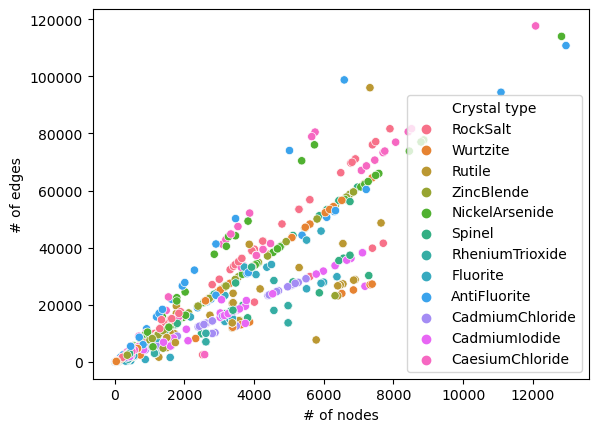

In [7]:
sns.scatterplot(data=stats2, x='# of nodes', y='# of edges', hue='Crystal type')
plt.show()

In [7]:
palette = sns.color_palette('tab10')
color_dict = {'Train': palette[0], 'Validation': palette[1], 'Test': palette[2]}
hue_order = ['Train', 'Validation', 'Test']

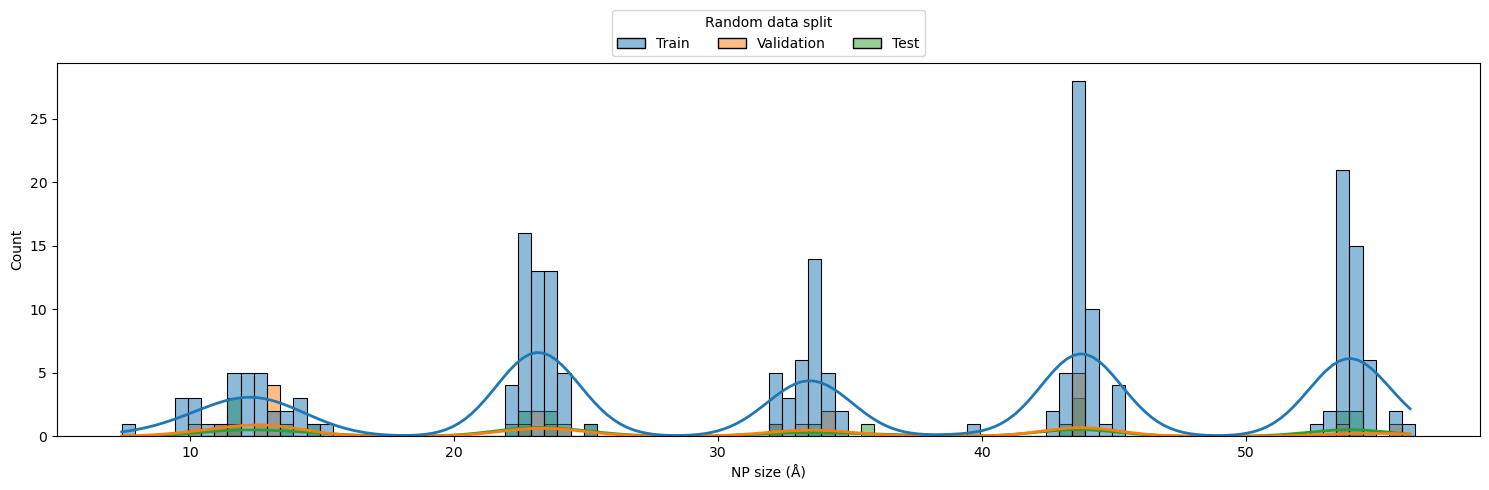

In [8]:
plt.figure(figsize=(15,5))
ax = sns.histplot(data=stats1, x='NP size (Å)', binwidth=0.5, hue='Random data split', multiple='layer',kde=True, kde_kws=dict(bw_method=0.1), line_kws=dict(linewidth=2), stat='count', palette=color_dict, hue_order=hue_order)
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
# plt.savefig('./test_stats_sizeDist.png', format='png', dpi=300)
plt.show()

plt.figure(figsize=(15,5))
ax = sns.histplot(data=stats2, x='NP size (Å)', binwidth=0.5, hue='Random data split', multiple='layer',kde=True, kde_kws=dict(bw_method=0.1), line_kws=dict(linewidth=2), stat='count', palette=color_dict, hue_order=hue_order)
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
# plt.savefig('./test_stats_sizeDist.png', format='png', dpi=300)
plt.show()

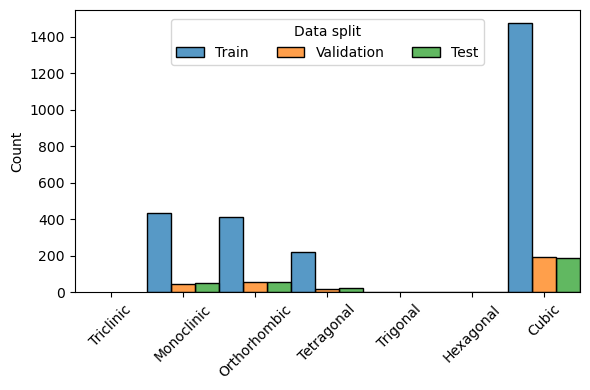

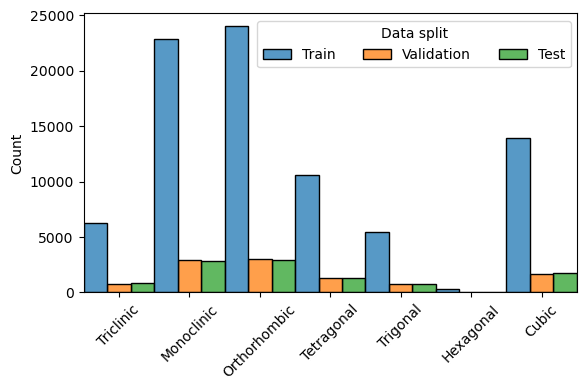

In [13]:
plt.figure(figsize=(6,4))
ax = sns.histplot(data=stats2, x='Crystal system (Number)', hue='Random data split', multiple='dodge', palette=color_dict, hue_order=hue_order, discrete=True)
# ax = sns.histplot(data=stats, x='Crystal type', hue='Stratified data split (Crystal type)', multiple='dodge', palette=color_dict, hue_order=hue_order)
# Change legend title
new_title = 'Data split'
ax.legend_.set_title(new_title)
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 0.78), ncol=3)
plt.xlim(-0.5, 6.5)
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Triclinic', 'Monoclinic', 'Orthorhombic', 'Tetragonal', 'Trigonal', 'Hexagonal', 'Cubic'], rotation=45)
# plt.xlabel('Crystal system')
plt.xlabel('')
plt.tight_layout()
# plt.savefig('./test_stats_crystalSystem_sim.pdf', format='pdf', dpi=300)
plt.show()

plt.figure(figsize=(6,4))
ax = sns.histplot(data=stats1, x='Crystal system (Number)', hue='Random data split', multiple='dodge', palette=color_dict, hue_order=hue_order, discrete=True)
# ax = sns.histplot(data=stats, x='Crystal type', hue='Stratified data split (Crystal type)', multiple='dodge', palette=color_dict, hue_order=hue_order)
# Change legend title
new_title = 'Data split'
ax.legend_.set_title(new_title)
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.67, 0.78), ncol=3)
plt.xlim(-0.5, 6.5)
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Triclinic', 'Monoclinic', 'Orthorhombic', 'Tetragonal', 'Trigonal', 'Hexagonal', 'Cubic'], rotation=45)
# plt.xlabel('Crystal system')
plt.xlabel('')
plt.tight_layout()
# plt.savefig('./test_stats_crystalSystem_COD.pdf', format='pdf', dpi=300)
plt.show()


In [23]:
stats1['Crystal system (Number)'].value_counts()

Crystal system (Number)
2    29975
1    28600
6    17353
3    13240
0     7870
4     6945
5      425
Name: count, dtype: int64

In [ ]:
# Plot to compare crystal system distribution in the two datasets
# plt.figure(figsize=(6,4))
# ax = sns.histplot(data=stats1, x='Crystal system (Number)', hue='Crystal system (Number)', multiple='dodge', palette=color_dict, hue_order=hue_order, discrete=True)
# sns.histplot(data=stats2, x='Crystal system (Number)', hue='Crystal system (Number)', multiple='dodge', palette=color_dict, hue_order=hue_order, discrete=True)
# # Change legend title
# new_title = 'Data split'


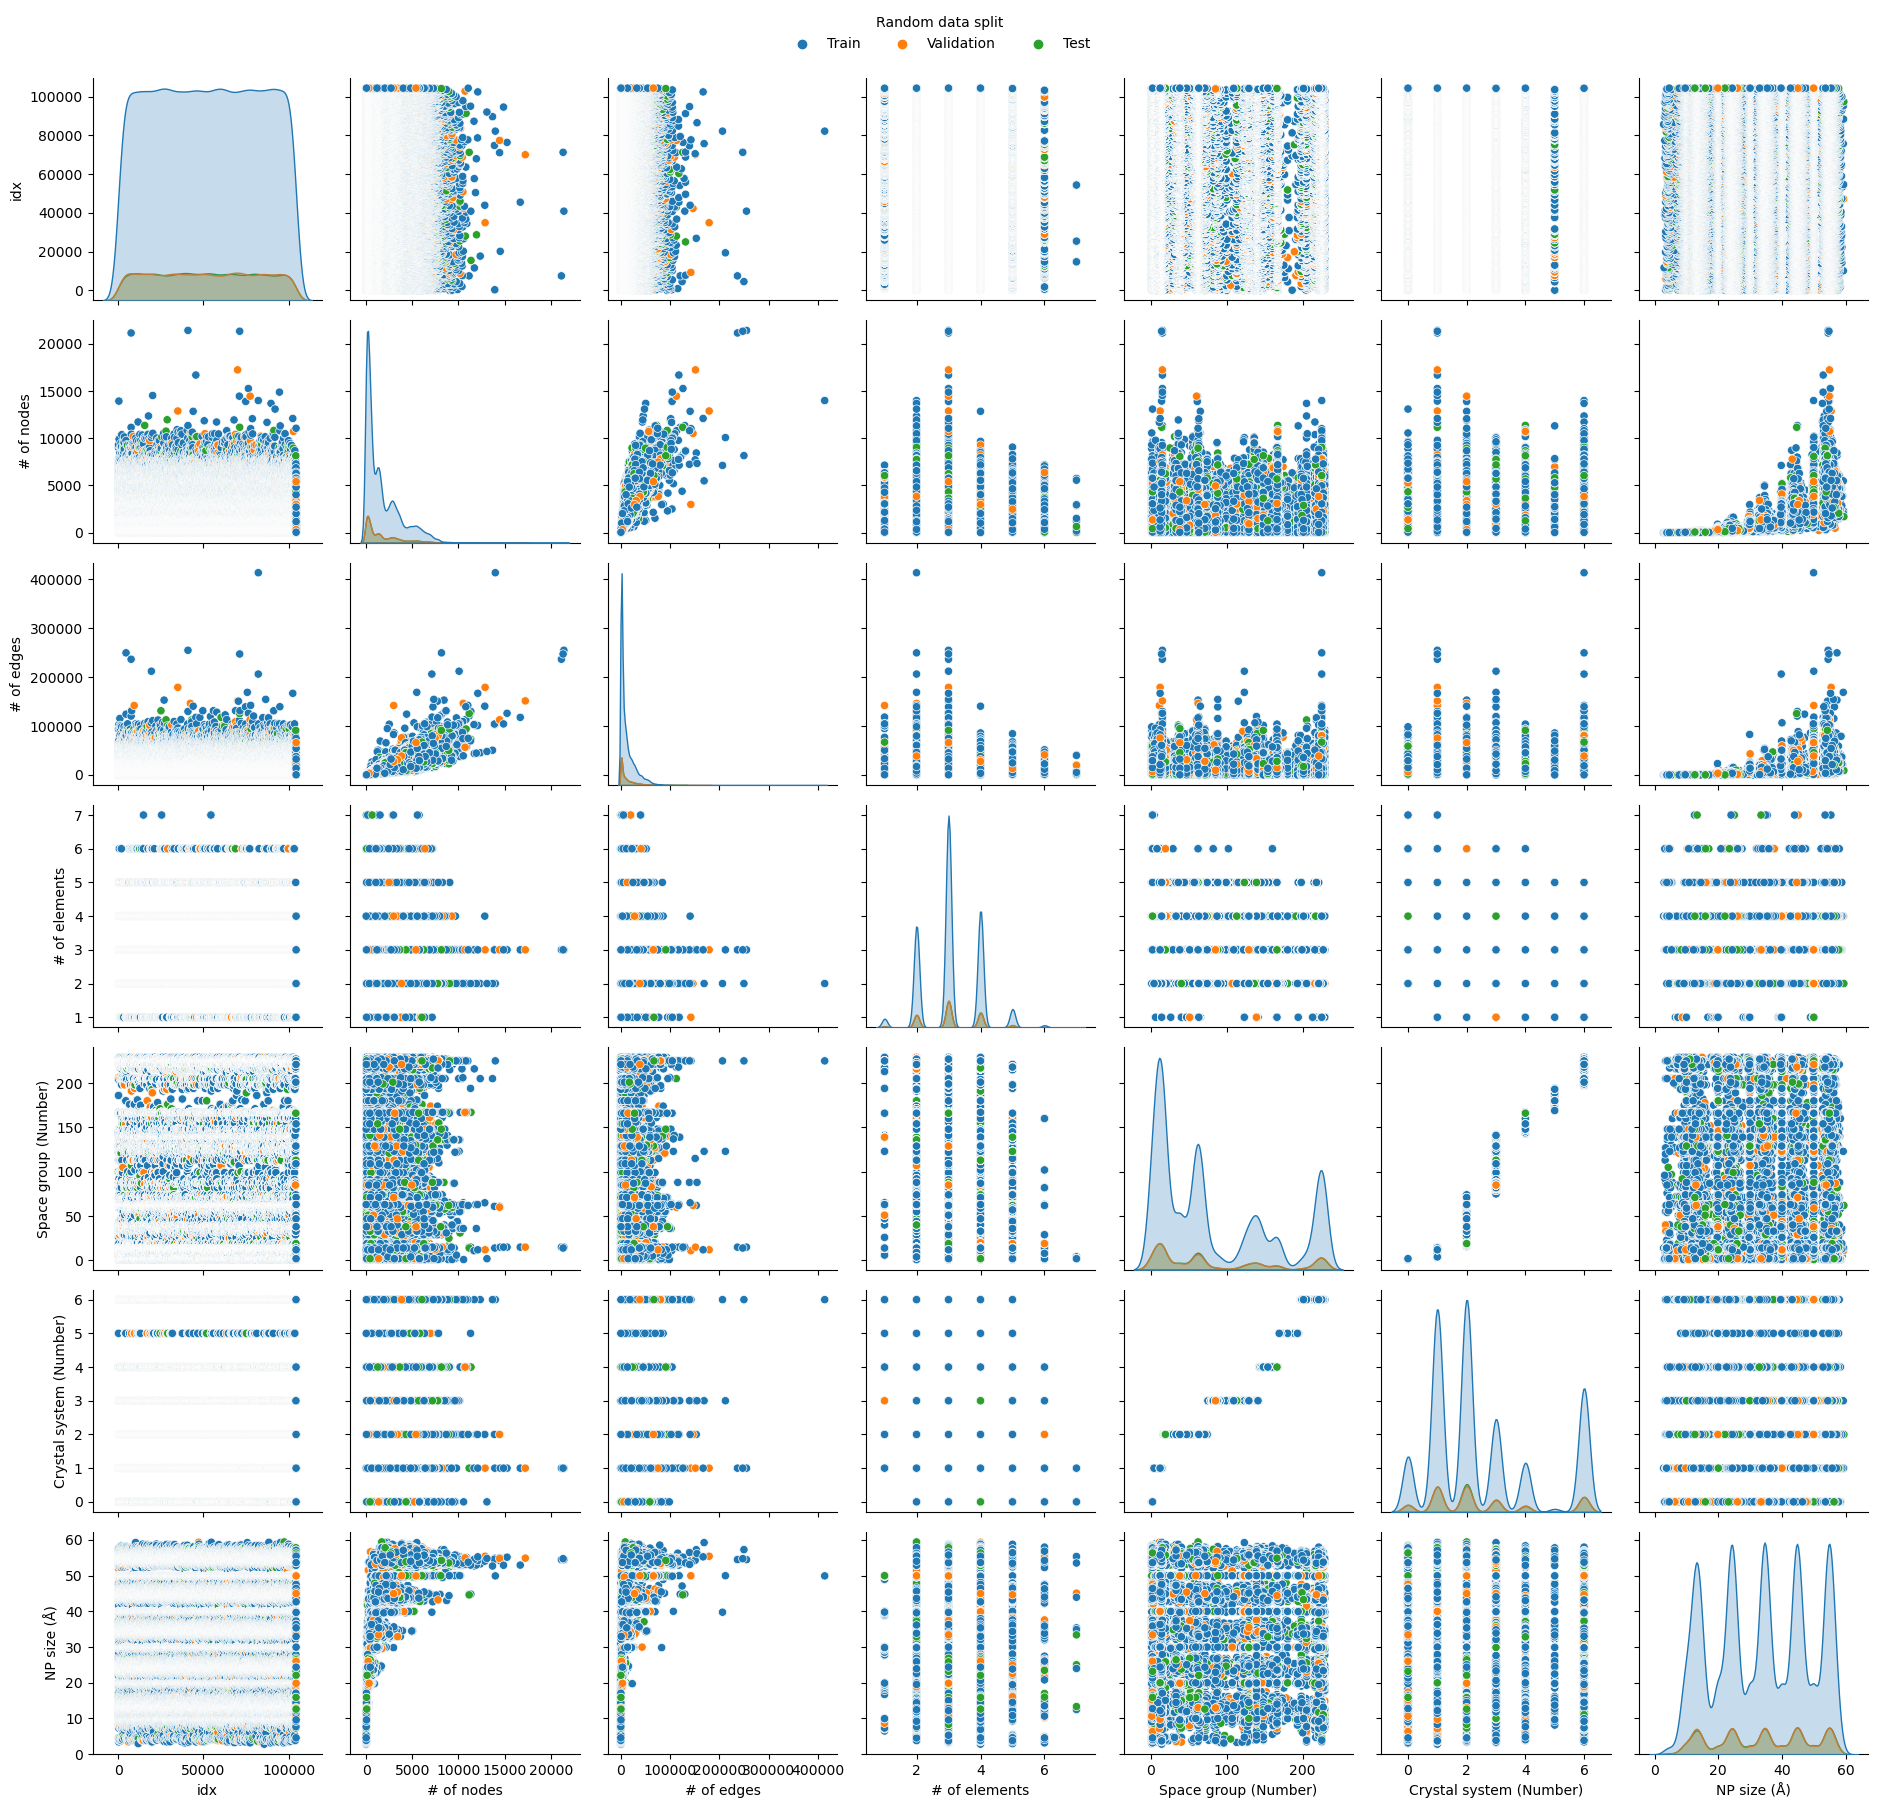

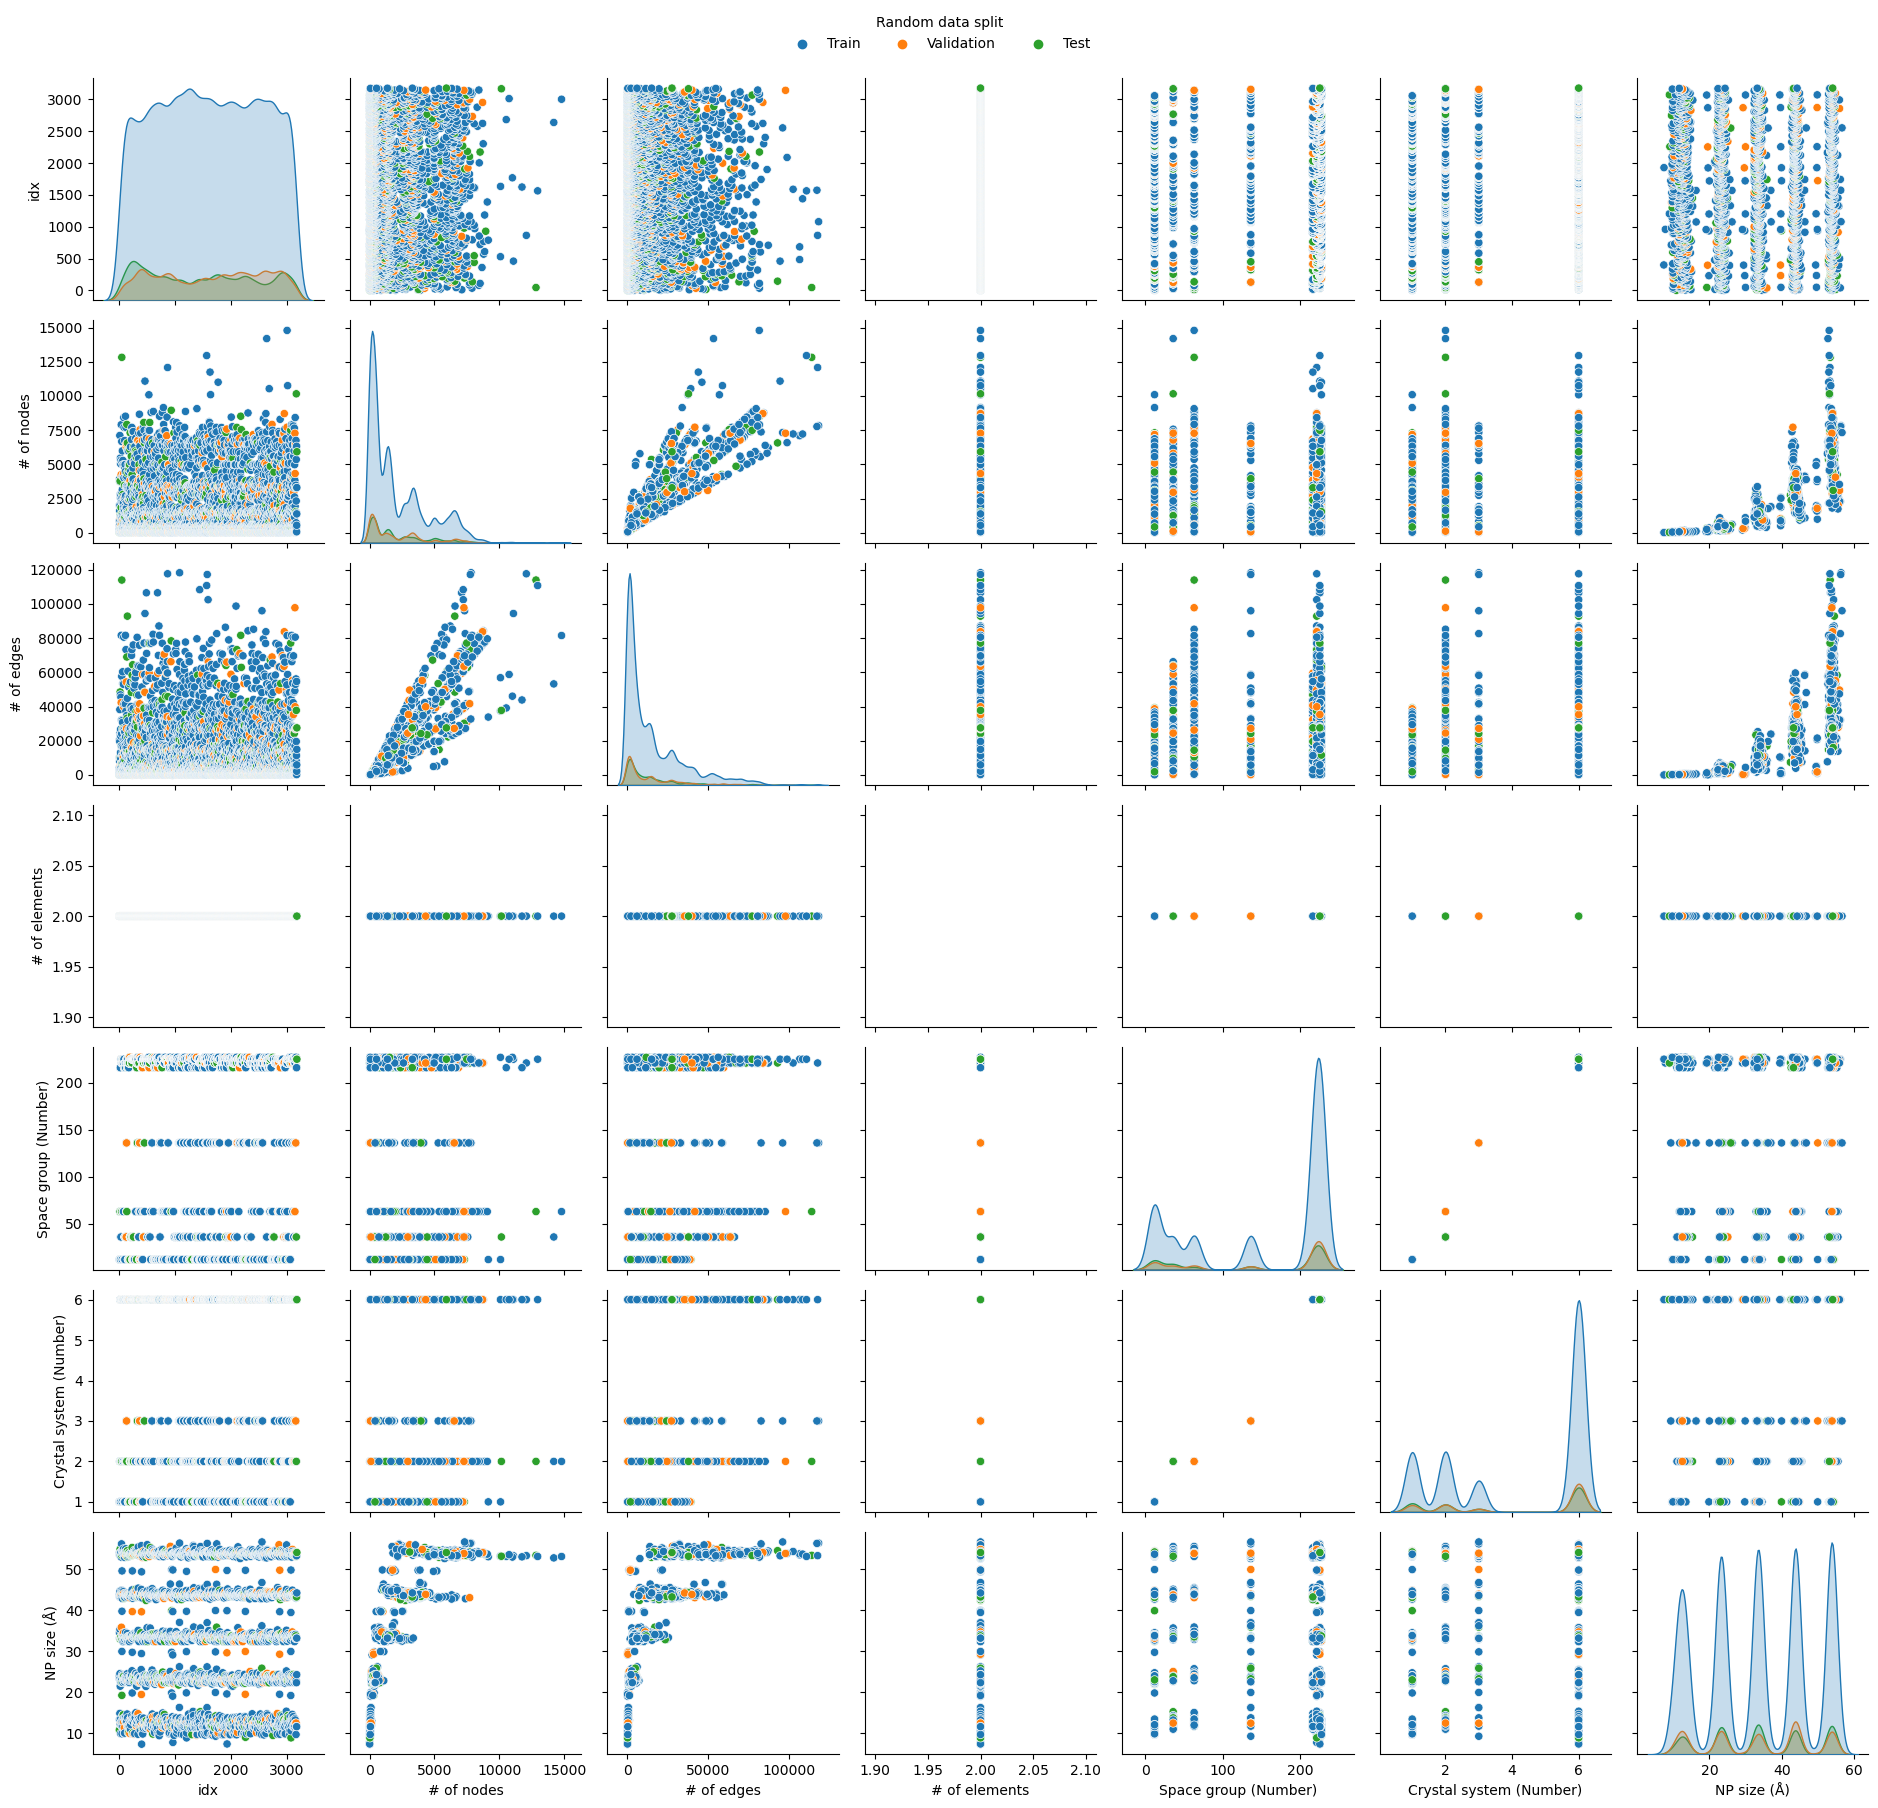

In [8]:
ax = sns.pairplot(data=stats1.drop('Elements', axis=1), hue='Random data split', diag_kws=dict(bw_method=0.1), palette=color_dict, hue_order=hue_order)
# ax = sns.pairplot(data=stats.drop('Elements', axis=1), hue='Stratified data split (Crystal type)', diag_kws=dict(bw_method=0.1), palette=color_dict, hue_order=hue_order)
# ax = sns.pairplot(data=stats.drop('Elements', axis=1), diag_kws=dict(bw_method=0.1))
# Change legend title
# new_title = 'Data split'
# ax.legend_.set_title(new_title)
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
plt.savefig('./test_stats_pairplot_COD.png', format='png', dpi=300)
plt.show()

#ax = sns.pairplot(data=stats, hue='Random data split', diag_kws=dict(bw_method=0.1))
ax = sns.pairplot(data=stats2.drop('Elements', axis=1), hue='Random data split', diag_kws=dict(bw_method=0.1), palette=color_dict, hue_order=hue_order)
# ax = sns.pairplot(data=stats.drop('Elements', axis=1), diag_kws=dict(bw_method=0.1))
# Change legend title
# new_title = 'Data split'
# ax.legend_.set_title(new_title)
sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.tight_layout()
plt.savefig('./test_stats_pairplot_sim.png', format='png', dpi=300)
plt.show()

# Results statistics

In [5]:
import os
import pandas as pd

# Specify the root directory
root_dir = './Results/Results_Only_GraphUNet/Simulated_rmax60_v4/'

# Initialize an empty list to store the dataframes
dfs = []

# Traverse the directory structure
for root, dirs, files in os.walk(root_dir):
    # Iterate over the files in the current directory
    for file in files:
        # Check if the file is a CSV file
        if file.endswith('.csv'):
            # Construct the full path to the CSV file
            file_path = os.path.join(root, file)
            
            # Read the CSV file into a dataframe
            df = pd.read_csv(file_path)
            
            # Append the dataframe to the list
            dfs.append(df)

# Concatenate all the dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True).drop('Unnamed: 0', axis=1)

combined_df['Val F1-score'] = combined_df['Val F1-score'].str.split('(').str[1].str.split(')').str[0].astype(float)
combined_df['Test F1-score'] = combined_df['Test F1-score'].str.split('(').str[1].str.split(')').str[0].astype(float)


In [6]:
combined_df.head()

,Model,Dataset,Task,Seed,Train samples,Val samples,Test samples,Train time,Trainable parameters,Train loss,Val F1-score,Test F1-score,Val posMAE/MSE,Test posMAE/MSE
0,GCN,Simulated_rmax60_v4,SAXSRegression,42,2544,318,318,2067.471238,2368,0.567137,NaN,NaN,2.326357,1.475145
1,GCN,Simulated_rmax60_v4,SAXSRegression,43,2544,318,318,1257.596675,2368,0.632457,NaN,NaN,2.739106,1.764506
2,GCN,Simulated_rmax60_v4,SAXSRegression,44,2544,318,318,772.013855,2368,0.635596,NaN,NaN,1.865514,1.284924
3,PMLP,Simulated_rmax60_v4,SAXSRegression,42,2544,318,318,426.145706,2368,9.962429,NaN,NaN,350.013100,349.503050
4,PMLP,Simulated_rmax60_v4,SAXSRegression,43,2544,318,318,562.140839,2368,10.500343,NaN,NaN,581.069200,333.984440


In [7]:
for task in combined_df['Task'].unique():
    print('\n\n')
    print(task)
    for model in combined_df['Model'].unique():
        print('')
        print(model)
        val_mae_mean = combined_df[(combined_df['Task'] == task) & (combined_df['Model'] == model)]['Val posMAE/MSE'].mean()
        val_mae_std = combined_df[(combined_df['Task'] == task) & (combined_df['Model'] == model)]['Val posMAE/MSE'].std()
        test_mae_mean = combined_df[(combined_df['Task'] == task) & (combined_df['Model'] == model)]['Test posMAE/MSE'].mean()
        test_mae_std = combined_df[(combined_df['Task'] == task) & (combined_df['Model'] == model)]['Test posMAE/MSE'].std()
        
        print(f'Val posMAE/MSE: ${val_mae_mean:.4f} \pm {val_mae_std:.4f}$')
        print(f'Test posMAE/MSE: ${test_mae_mean:.4f} \pm {test_mae_std:.4f}$')
        
        val_f1_mean = combined_df[(combined_df['Task'] == task) & (combined_df['Model'] == model)]['Val F1-score'].mean()
        val_f1_std = combined_df[(combined_df['Task'] == task) & (combined_df['Model'] == model)]['Val F1-score'].std()
        test_f1_mean = combined_df[(combined_df['Task'] == task) & (combined_df['Model'] == model)]['Test F1-score'].mean()
        test_f1_std = combined_df[(combined_df['Task'] == task) & (combined_df['Model'] == model)]['Test F1-score'].std()
        
        print(f'Val F1-score: ${val_f1_mean:.4f} \pm {val_f1_std:.4f}$')
        print(f'Test F1-score: ${test_f1_mean:.4f} \pm {test_f1_std:.4f}$')
    




SAXSRegression

GCN
Val posMAE/MSE: $2.3103 \pm 0.4370$
Test posMAE/MSE: $1.5082 \pm 0.2415$
Val F1-score: $nan \pm nan$
Test F1-score: $nan \pm nan$

PMLP
Val posMAE/MSE: $491.1405 \pm 123.7445$
Test posMAE/MSE: $317.0038 \pm 43.5478$
Val F1-score: $nan \pm nan$
Test F1-score: $nan \pm nan$

GAT
Val posMAE/MSE: $2.3484 \pm 0.4700$
Test posMAE/MSE: $1.3419 \pm 0.1827$
Val F1-score: $nan \pm nan$
Test F1-score: $nan \pm nan$

GIN
Val posMAE/MSE: $2.4524 \pm 1.8826$
Test posMAE/MSE: $1.5540 \pm 0.5176$
Val F1-score: $nan \pm nan$
Test F1-score: $nan \pm nan$

GraphSAGE
Val posMAE/MSE: $2.2431 \pm 0.7296$
Test posMAE/MSE: $1.5868 \pm 0.2704$
Val F1-score: $nan \pm nan$
Test F1-score: $nan \pm nan$

GraphUNet
Val posMAE/MSE: $2.6685 \pm 0.4529$
Test posMAE/MSE: $1.7222 \pm 0.3350$
Val F1-score: $nan \pm nan$
Test F1-score: $nan \pm nan$

EdgeCNN
Val posMAE/MSE: $2.6806 \pm 1.6619$
Test posMAE/MSE: $1.2066 \pm 0.1644$
Val F1-score: $nan \pm nan$
Test F1-score: $nan \pm nan$



PositionRe